In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacrev, jacfwd
from jax import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
def random_layer_params(m, n, scale, key):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), 1e-6 * random.normal(b_key, (n,))

def init_network_params(sizes, scale, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, scale, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


#used for classification
batch_size = 128
n_targets = 10

We consider a teacher-student model given by

$$
\begin{cases}
Y_{in} = W_{in} x\\
Y_h = Y_{in} + (W_h + BA)\phi(Y_{in})\\
Y_{out}=W_{out}\phi(Y_h)
\end{cases}
$$

where $B, A^\top \in \mathbb{R}^{n\times r}$, $W_{in} \in \mathbb{R}^{n\times d}, W_h\in\mathbb{R}^{n\times n}, W_{out}\in \mathbb{R}^{1\times n}$.


We use the following hyperparameters:


*   $r_{teacher} = 20$
*   $r_{student} = 4$
*   $d = 5, n=100$



In [ ]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def tanh(x):
  return jnp.tanh(x)

def predict(params, x):
  # per-example predictions
  Win, Wh, A, B, Wout = params[0], params[1], params[2], params[3], params[4]
  layer = jnp.dot(Win, x)
  layer= layer + jnp.dot(jnp.dot(B, A),relu(layer))
  return jnp.dot(Wout, relu(layer))
batched_predict = vmap(predict, in_axes=(None, 0))

def predict_linear(params, x):
  # per-example predictions
  A, B, Wout = params[0], params[1], params[2]
  return jnp.dot(Wout + jnp.dot(B, A), x)

#batched version of predict
batched_predict_linear = vmap(predict_linear, in_axes=(None, 0))


def predict_optimized(params_lora, other_params, x):
  # per-example predictions
  A, B = params_lora[0], params_lora[1]
  Win, Wh, Wout = other_params[0], other_params[1], other_params[2]
  layer = jnp.dot(Win, x)
  layer= jnp.dot(Wh + jnp.dot(B, A),relu(layer))
  return jnp.dot(Wout, relu(layer))

#batched version of predict
batched_predict_optimized = vmap(predict_optimized, in_axes=(None, None, 0))

In [ ]:
def loss(params, inputs, targets):
  preds = batched_predict(params, inputs)
  return jnp.mean((preds - targets)**2)

def loss_linear(params, inputs, targets):
  preds = batched_predict_linear(params, inputs)
  return jnp.mean((preds - targets)**2)

def loss_optimized(params_lora, other_params, inputs, targets):
  preds = batched_predict_optimized(params_lora, other_params, inputs)
  return jnp.mean((preds - targets)**2)

def func(param, x ,y):
  return (jnp.sum(param[0]*x) - y)**2

@jit
def update(params, x, y, lr_in, lr_out):
  lrs = [0, 0, lr_out, lr_in, 0]
  grads = grad(loss)(params, x, y)
  return [w - lrs[i] * dw
          for i, (w, dw) in enumerate(zip(params, grads))]


@jit
def adam(params, m_prev, v_prev, t, x, y, lr):
  b1, b2 = 0.9, 0.99
  lrs = [0, 0, lr, lr, 0]
  grads = grad(loss)(params, x, y)
  M = [b1*m + (1.0-b1)*dw for i, (m,dw) in enumerate(zip(m_prev, grads))]
  V = [b2*v + (1.0-b2)*(dw**2) for i, (v,dw) in enumerate(zip(v_prev, grads))]
  scaled_M = [(1/(1-b1**t))*m for m in M]
  scaled_V = [(1/(1-b2**t))*v for v in V]
  return [[w - lrs[i] * m/(jnp.sqrt(v)+1e-8)
          for i, (w, m, v) in enumerate(zip(params, scaled_M, scaled_V))], M, V]


@jit
def adam_linear(params, m_prev, v_prev, t, x, y, lr):
  b1, b2 = 0.9, 0.99
  lrs = [lr, lr, 0]
  grads = grad(loss_linear)(params, x, y)
  M = [b1*m + (1.0-b1)*dw for i, (m,dw) in enumerate(zip(m_prev, grads))]
  V = [b2*v + (1.0-b2)*(dw**2) for i, (v,dw) in enumerate(zip(v_prev, grads))]
  scaled_M = [(1/(1-b1**t))*m for m in M]
  scaled_V = [(1/(1-b2**t))*v for v in V]
  return [[w - lrs[i] * m/(jnp.sqrt(v)+1e-8)
          for i, (w, m, v) in enumerate(zip(params, scaled_M, scaled_V))], M, V]


@jit
def adam_optimized(params_lora, other_params, m_prev, v_prev, t, x, y, lr):
  lrs = [lr, lr]
  grads = grad(loss_optimized)(params_lora, other_params, x, y)
  M = [0.9*m + 0.1*dw for i, (m,dw) in enumerate(zip(m_prev, grads))]
  V = [0.99*v + 0.01*(dw**2) for i, (v,dw) in enumerate(zip(v_prev, grads))]
  scaled_M = [(1/(1-0.9**t))*m for m in M]
  scaled_V = [(1/(1-0.99**t))*v for v in V]
  return [[w - lrs[i] * m/(jnp.sqrt(v)+1e-8)
          for i, (w, m, v) in enumerate(zip(params_lora, scaled_M, scaled_V))], M, V]

In [ ]:
#Data

N=1000 #nb samples
N_test = 100
d=5 #input dim
r=4 #lora rank

s1,s2 = random.split(random.PRNGKey(111), num=2)
w= np.ones(d)
X = random.uniform(s1, (N,d))
# Y = np.sin(X.dot(w))
X_test = random.uniform(s2, (N_test,d))
# Y_test = np.sin(X_test.dot(w))


s1, s2, s3, s4, s5, s6, s7 = random.split(random.PRNGKey(10), num=7)

n=1000
r_synth = 20
Win_ = 1/np.sqrt(d)*random.normal(s1, (n,d))
Wh_ = 1/np.sqrt(n)*random.normal(s2, (n,n))
A_ = 1/np.sqrt(n) * random.normal(s5, (r_synth,n))
B_ = 1./np.sqrt(r_synth)*random.normal(s6, (n,r_synth))
Wout_ = 1./np.sqrt(n) * random.normal(s4, (1,n))

#generate synthetic data
X_test = random.normal(s7, (N_test,d))
synth_params = [Win_, Wh_, A_, B_, Wout_]
Y = batched_predict(synth_params, X)
Y_test = batched_predict(synth_params, X_test)

KeyboardInterrupt: 

In [ ]:
jnp.abs(jnp.dot(B_,jnp.dot(A_, jnp.dot(Win_,X.T)))).mean(axis=1).mean()

Array(0.39791292, dtype=float32)

#** FULL SWEEP**

In [ ]:
import tqdm

In [ ]:
r_synth = 20
def sweep_n(lrs, n, res, nb_steps, save_freq, seeds, init=1):
  for seed in seeds:
    s1, s2, s3, s4, s5, s6 = random.split(random.PRNGKey(seed), num=6)
    Win = 1/np.sqrt(d)*random.normal(s1, (n,d))
    Wh = 1/np.sqrt(n)*random.normal(s2, (n,n))
    #A = 1/np.sqrt(n) * random.normal(s3, (r,n))
    if init==2:
      B = 1./np.sqrt(r)*random.normal(s3, (n,r))
      A = jnp.zeros((r,n))#1/np.sqrt(n) * random.normal(se+2, (r,n))

    elif init==1:
      B = jnp.zeros((n,r))#1./np.sqrt(r)*random.normal(se+3, (n,r))
      A = 1/np.sqrt(n) * random.normal(s3, (r,n))

    Wout = 1./np.sqrt(n) * random.normal(s4, (1,n))

    #generate synthetic data
    #1/np.sqrt(n) * random.normal(s5, (r_synth,n))
    # synth_params = [Win, Wh, 1/np.sqrt(n)*random.normal(s5, (r_synth, n)), 1./np.sqrt(r_synth)*random.normal(s6, (n,r_synth)), Wout]
    # Y = batched_predict(synth_params, X)
    # Y_test = batched_predict(synth_params, X_test)

    #adam(params, m_prev, v_prev, t, x, y, lr_in, lr_out)
    params = [Win, Wh, A, B, Wout]
    for i, lr in enumerate(lrs):
      if i%20==0:
        print("lr="+str(lr) + ", ind=" + str(i) +", seed="+str(seed))

      new_params = params
      m = [jnp.zeros_like(p) for p in params]
      v = [jnp.zeros_like(p) for p in params]
      for j in range(nb_steps+1):
        if j%save_freq==0:
          A_,B_ = new_params[2:4]
          Az = jnp.abs(jnp.dot(A_, jnp.dot(Win,X.T))).mean(axis=1).tolist()
          BAz = jnp.abs(jnp.dot(B_, jnp.dot(A_, jnp.dot(Win,X.T)))).mean(axis=1).tolist()
          res.append([n, lr, j, seed, float(loss(new_params, X, Y)), float(loss(new_params, X_test, Y_test)), Az, BAz])
        new_params, m, v = adam(new_params, m, v, j+1, X, Y, lr)
  #   df = pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])
  # return pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])


def full_sweep(lrs, list_n, nb_steps, save_freq, seeds, title, init=1):
  res = []
  for n in tqdm.tqdm(list_n):
    print("************* n="+str(n)+" ****************\n")
    print('\n')
    sweep_n(lrs, n, res, nb_steps, save_freq, seeds, init)
    df = pd.DataFrame(res, columns=['n', 'lr', 'step', 'seed', 'train_loss', 'test_loss', 'Az', 'BAz'])
    df.to_csv(title+".csv")
  return df

In [ ]:
lrs = list(2**np.linspace(0, 15, 60)*1e-5)
#list_n = [2**k for k in range(6,12)]
list_n = [2**k for k in range(6,14)]

nb_steps = 100

#[90231, 101504, 232300]

df1 = full_sweep(lrs, list_n, nb_steps, 2, [k for k in range(10)], title='full_sweep_init1', init=1)
df2 = full_sweep(lrs, list_n, nb_steps, 2, [k for k in range(10)], title='full_sweep_init2', init=2)


#files.download('full_sweep_init1.csv')

  0%|          | 0/8 [00:00<?, ?it/s]

************* n=64 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0,

 12%|█▎        | 1/8 [04:47<33:30, 287.28s/it]

************* n=128 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 25%|██▌       | 2/8 [09:41<29:06, 291.07s/it]

************* n=256 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 38%|███▊      | 3/8 [14:45<24:44, 297.00s/it]

************* n=512 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 50%|█████     | 4/8 [20:01<20:18, 304.66s/it]

************* n=1024 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 62%|██████▎   | 5/8 [26:18<16:32, 330.76s/it]

************* n=2048 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 75%|███████▌  | 6/8 [35:17<13:23, 401.73s/it]

************* n=4096 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 88%|████████▊ | 7/8 [52:14<10:02, 602.80s/it]

************* n=8192 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

  0%|          | 0/8 [00:00<?, ?it/s]

************* n=64 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0,

 12%|█▎        | 1/8 [04:43<33:05, 283.71s/it]

************* n=128 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 25%|██▌       | 2/8 [09:32<28:39, 286.58s/it]

************* n=256 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 38%|███▊      | 3/8 [14:35<24:30, 294.07s/it]

************* n=512 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=0

 50%|█████     | 4/8 [19:49<20:07, 301.95s/it]

************* n=1024 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 62%|██████▎   | 5/8 [26:02<16:22, 327.59s/it]

************* n=2048 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 75%|███████▌  | 6/8 [35:09<13:24, 402.21s/it]

************* n=4096 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

 88%|████████▊ | 7/8 [52:12<10:05, 605.33s/it]

************* n=8192 ****************



lr=1e-05, ind=0, seed=0
lr=0.0003393602685918488, ind=20, seed=0
lr=0.011516539189873177, ind=40, seed=0
lr=1e-05, ind=0, seed=1
lr=0.0003393602685918488, ind=20, seed=1
lr=0.011516539189873177, ind=40, seed=1
lr=1e-05, ind=0, seed=2
lr=0.0003393602685918488, ind=20, seed=2
lr=0.011516539189873177, ind=40, seed=2
lr=1e-05, ind=0, seed=3
lr=0.0003393602685918488, ind=20, seed=3
lr=0.011516539189873177, ind=40, seed=3
lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5
lr=1e-05, ind=0, seed=6
lr=0.0003393602685918488, ind=20, seed=6
lr=0.011516539189873177, ind=40, seed=6
lr=1e-05, ind=0, seed=7
lr=0.0003393602685918488, ind=20, seed=7
lr=0.011516539189873177, ind=40, seed=7
lr=1e-05, ind=0, seed=8
lr=0.0003393602685918488, ind=20, seed=8
lr=0.011516539189873177, ind=40, seed=8
lr=1e-05, ind=

100%|██████████| 8/8 [1:39:36<00:00, 747.09s/it] 


In [ ]:
# import csv
df1 = pd.read_csv('/content/init1_full.csv',engine='python')
df2 = pd.read_csv('/content/init2_full.csv',engine='python')

In [ ]:
def get_best_lr(data, n, step):
  dt = data[(data['n']==n) & (data['step']==step)]
  seeds = dt['seed'].unique()
  best_lr = []
  for seed in seeds:
    dt_ = dt[dt['seed']==seed]
    best = dt_['train_loss'].min()
    #print(dt_)
    #print('***************** Best Train Loss at step {step} = {best}******************\n'.format(step=step, best=best))
    for i in range(len(dt_)):
      if (dt_.iloc[i]['train_loss']==best):
        best_lr.append([n, dt_.iloc[i]['lr']])
  return best_lr

def get_best_lr2(data, n, steps):
  dt = data[(data['n']==n) & (data['step'].isin(steps))]
  dt = dt.groupby(['lr', 'seed'], as_index=False).mean()
  seeds = dt['seed'].unique()
  best_lr = []
  for seed in seeds:
    dt_ = dt[dt['seed']==seed]
    best = dt_['train_loss'].min()
    #print(dt_)
    #print('***************** Best Train Loss at step {step} = {best}******************\n'.format(step=step, best=best))
    for i in range(len(dt_)):
      if (dt_.iloc[i]['train_loss']==best):
        best_lr.append([n, dt_.iloc[i]['lr']])
  return best_lr

In [ ]:
get_best_lr(df2, 2048, 100)

[[2048, 0.0011651781800251],
 [2048, 0.0011651781800251],
 [2048, 0.0013897138727557],
 [2048, 0.0016575187222335],
 [2048, 0.0006867413436834],
 [2048, 0.0006867413436834],
 [2048, 0.0016575187222335],
 [2048, 0.0013897138727557],
 [2048, 0.0016575187222335],
 [2048, 0.0019769309124812]]

In [ ]:
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

Text(0.7, 0.85, 'Tradeoff')

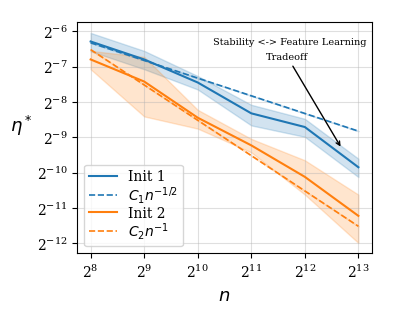

In [ ]:
import scipy
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

cm = sns.color_palette()#sns.color_palette("Set2")#sns.color_palette('tab10')

th = 2

list_n = [2**k for k in range(6,14)]

best_lrs1 = []
best_lrs2 = []

seeds = [6,7,8,9]
seeds2 = [6,7,8,9]

for n in list_n[th:]:
  best_lrs1 += get_best_lr(df1[df1['seed'].isin(seeds)], n, 100)
  best_lrs2 += get_best_lr(df2[df2['seed'].isin(seeds2)], n, 100)


# best_lrs1 = [get_best_lr(df1, n, 300) for n in list_n[th:]]
# best_lrs2 = [get_best_lr(df2, n, 300) for n in list_n[th:]]


df_lrs1 = pd.DataFrame(best_lrs1, columns=['n','lr'])
df_lrs2 = pd.DataFrame(best_lrs2, columns=['n','lr'])

fig, ax = plt.subplots(figsize=(3.8,3))

df_lrs1['log2_lr']=np.log(df_lrs1['lr'])/np.log(2)
df_lrs1['log2_n']=np.log(df_lrs1['n'])/np.log(2)

df_lrs2['log2_lr']=np.log(df_lrs2['lr'])/np.log(2)
df_lrs2['log2_n']=np.log(df_lrs2['n'])/np.log(2)

df_lrs1['th']= 0.2*df_lrs1['n']**(-.5)
df_lrs2['th']= 2.8*df_lrs1['n']**(-1.)

# ax.plot(list_n[th:], 0.2*np.array(list_n[th:])**(-.5), label=r'$C_1 n^{-1/2}$', color=cm[0], linestyle='--', linewidth=1.2, alpha=0.8)

# ax.plot(list_n[th:], 3.1*np.array(list_n[th:])**(-1.),label=r'$C_2 n^{-1}$', color=cm[3], linestyle='--', linewidth=1.2, alpha=0.8)


sns.lineplot(data=df_lrs1, x='n', y='lr', color=cm[0], ax=ax, label='Init 1')
sns.lineplot(data=df_lrs1, x='n', y='th', color=cm[0], ax=ax, label=r'$C_1 n^{-1/2}$', linestyle='--', linewidth=1.2, alpha=1.)

sns.lineplot(data=df_lrs2, x='n', y='lr', color=cm[1], ax=ax, label='Init 2')
sns.lineplot(data=df_lrs2, x='n', y='th', color=cm[1], ax=ax, label=r'$C_2 n^{-1}$', linestyle='--', linewidth=1.2, alpha=1.)


# p = sns.lineplot(data=df_lrs1, x='log2_n', y='log2_lr', color=cm[0], ax=ax, label='Init 1')
# p2 = sns.lineplot(data=df_lrs2, x='log2_n', y='log2_lr', color=cm[3], ax=ax, label='Init 2')

#sns.lineplot(data=df_lrs2, x='n', y='lr', ax=ax)

# ax.plot(list_n[th:], best_lrs1, color='red', linestyle='-')
# ax.plot(list_n[th:], best_lrs2, color='blue')


ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

# slope, intercept, R, P, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
#                                                        y=p.get_lines()[0].get_ydata())

# slope2, intercept, R, P, sterr = scipy.stats.linregress(x=p2.get_lines()[0].get_xdata(),
#                                                        y=p2.get_lines()[0].get_ydata())

ax.grid(alpha=0.4)
# ax.set_xticklabels(['','$2^8$', '$2^9$', '$2^{10}$', '$2^{11}$', '$2^{12}$', '$2^{13}$'])
# ax.set_yticklabels(['','$2^{-12}$', '$2^{-11}$', '$2^{-10}$', '$2^{-9}$', '$2^{-8}$','$2^{-7}$','$2^{-6}$'])

ax.set_xlabel(r'$n$', fontsize=13)
ax.set_ylabel(r'$\eta^*$', rotation=0, fontsize=13)

ax.yaxis.set_label_coords(-0.19,0.5)

#ax.legend().set_visible(False)

L = ax.legend(labelspacing=.05, borderpad=0.35, loc='lower left')
#plt.setp(L.texts, family='Times New Roman')

ax.annotate('Stability <-> Feature Learning', xy=(0.56, 0.9),
            xycoords='figure fraction', fontsize=7)
ax.annotate('Tradeoff', xy=(0.9, 0.55), xytext=(0.7, 0.85),
            xycoords='figure fraction', textcoords='figure fraction', fontsize=7,
            arrowprops=dict(arrowstyle="->"))
#print(slope, slope2)
#fig.savefig('opt_lr.pdf', bbox_inches='tight')


In [ ]:
lr1 = get_best_lr(df1, 4096, 100)[0][1]
df1[(df1['lr']==lr1) & (df1['seed']==0)]


,Unnamed: 0,n,lr,step,seed,train_loss,test_loss,Az_,BAz_
1428,1428,64,0.00139,0,0,0.202752,1.742944,0.555098,0.000000
1429,1429,64,0.00139,2,0,0.200478,1.740145,0.559002,0.003815
1430,1430,64,0.00139,4,0,0.197692,1.734871,0.568395,0.007841
1431,1431,64,0.00139,6,0,0.194309,1.726500,0.576882,0.012208
1432,1432,64,0.00139,8,0,0.190370,1.714606,0.586880,0.016853
...,...,...,...,...,...,...,...,...,...
215674,215674,8192,0.00139,92,0,0.000429,2.206318,3.988490,0.034940
215675,215675,8192,0.00139,94,0,0.000420,2.196235,3.974659,0.034764
215676,215676,8192,0.00139,96,0,0.000399,2.184052,3.968739,0.034803
215677,215677,8192,0.00139,98,0,0.000382,2.175292,3.963367,0.034804


In [ ]:
df1['Az_'] = np.array([np.array(t) for t in df1['Az'].values]).mean(axis=1)
df1['BAz_'] = np.array([np.array(t).mean() for t in df1['BAz'].values])

In [ ]:
df2['Az_'] = np.array([np.array(t) for t in df2['Az'].values]).mean(axis=1)
df2['BAz_'] = np.array([np.array(t).mean() for t in df2['BAz'].values])

In [ ]:
df1_ = df1[['n', 'lr', 'step', 'seed', 'train_loss', 'test_loss', 'Az_', 'BAz_']]
df1_.to_csv('init1_full.csv')

df2_ = df2[['n', 'lr', 'step', 'seed', 'train_loss', 'test_loss', 'Az_', 'BAz_']]
df2_.to_csv('init2_full.csv')

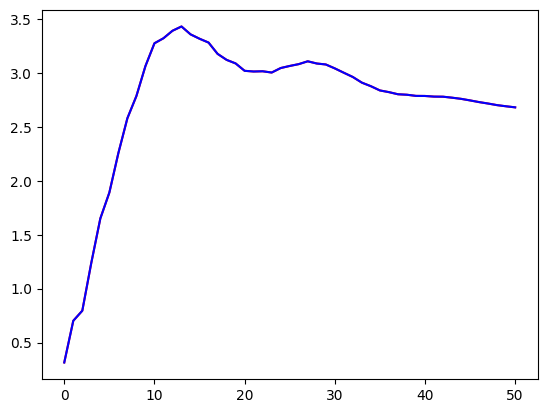

In [ ]:
lr = get_best_lr(df1, n, 100)[0][1]
dt = df1[(df1['lr']==lr) & (df1['seed']==0) & (df1['n']==n)]
dt

plt.plot(np.array([np.array(t) for t in dt['Az'].values]).mean(axis=1), label='Az', color='red')


plt.plot(np.array([np.mean(t) for t in dt['Az'].values]), label='Az', color='blue')


In [ ]:
n=8192
step=100
df = df1
lr = get_best_lr(df, n, step)[5][1]
dt = df[(df['lr']==lr) & (df['seed']==5) & (df['n']==n)]

In [ ]:
dt

,Unnamed: 0,n,lr,step,seed,train_loss,test_loss,Az_,BAz_
230979,230979,8192,0.001658,0,5,0.294670,2.399036,0.241376,0.000000
230980,230980,8192,0.001658,2,5,0.399660,1.888893,1.462524,0.012061
230981,230981,8192,0.001658,4,5,0.198372,1.656963,1.179166,0.006516
230982,230982,8192,0.001658,6,5,0.180058,1.818636,2.016560,0.013165
230983,230983,8192,0.001658,8,5,0.050339,2.048785,2.836572,0.024088
230984,230984,8192,0.001658,10,5,0.114250,5.317442,3.537136,0.036869
230985,230985,8192,0.001658,12,5,0.021831,3.846545,3.877195,0.038279
230986,230986,8192,0.001658,14,5,0.063373,2.122215,4.087021,0.036848
230987,230987,8192,0.001658,16,5,0.039779,2.097976,4.249843,0.038850
230988,230988,8192,0.001658,18,5,0.019561,3.056537,4.443406,0.043947


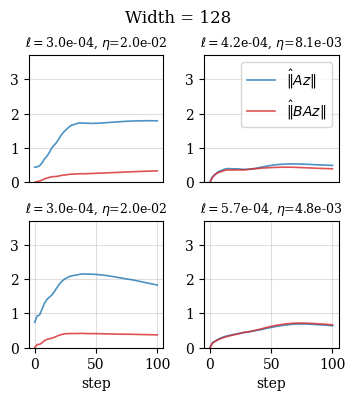

In [ ]:
n=128
step=100
# def plot_avg(ax, df, seed, ind):
#   lr = get_best_lr(df, n, step)[ind][1]
#   dt = df[(df['lr']==lr) & (df['seed']==seed) & (df['n']==n)]
#   #print(dt['Az'])
#   ax.plot(np.array([np.array(t) for t in dt['Az'].values]).mean(axis=1), label='Az', color='red')
#   ax.plot(np.array([np.array(t) for t in dt['BAz'].values]).mean(axis=1), label='BAz', color='blue')
#   ax.set_title("{:0.5f}".format(min(dt['train_loss']))+", lr={:0.5f}".format(lr))
#   ax.legend()

# def plot_best_loss(ax, df, seed, ind):
#   lr = get_best_lr(df, n, step)[ind][1]
#   dt = df[(df['lr']==lr) & (df['seed']==seed) & (df['n']==n)]
#   ax.plot(dt['train_loss'].values, label='train_loss')
#   ax.set_title("train_loss")
#   ax.legend()
cm = sns.color_palette('tab10')


def plot_avg(ax, df, n, seed, ind, ylim=[0. ,4.]):
  lr = get_best_lr(df, n, step)[ind][1]
  dt = df[(df['lr']==lr) & (df['seed']==seed) & (df['n']==n)]
  #print(dt['Az'])
  ax.plot([2*k for k in range(51)],dt['Az_'].values, label='$\hat{\|}Az\|$', color=cm[0], linewidth=1.2, alpha=0.8)
  ax.plot([2*k for k in range(51)],dt['BAz_'].values, label='$\hat{\|}BAz\|$', color=cm[3], linewidth=1.2, alpha=0.8)
  ax.set_title("$\ell=$""{:0.1e}".format(min(dt['train_loss']))+", $\eta$={:0.1e}".format(lr), fontsize=9)
  ax.set_ylim(ylim)
  ax.legend()



def plot_best_loss(ax, df, n, seed, ind, title, col='blue', ylim=[0. ,1e-2]):
  lr = get_best_lr(df, n, step)[ind][1]
  dt = df[(df['lr']==lr) & (df['seed']==seed) & (df['n']==n)]
  ax.plot([2*k for k in range(51)], dt['train_loss'].values, label=title, color=col)
  ax.set_title("train_loss")
  ax.set_ylim(ylim)
  ax.legend()


fig, axes = plt.subplots(2,2, figsize=(4,3.8))


for i in range(2):
  axes[0,i].grid(alpha=0.4)
  axes[1,i].grid(alpha=0.4)



s1=8
i1=8

s2=6
i2=6

plot_avg(axes[0,0], df1, n, s1, i1, ylim=[0.,3.7])
plot_avg(axes[0,1], df2, n, s1, i1, ylim=[0.,3.7])
# plot_best_loss(axes[0,2], df1, s1, i1, 'init1', col=cm[0])
# plot_best_loss(axes[0,2], df2, s1, i1, 'init2', col=cm[3])
plot_avg(axes[1,0], df1, n, s2, i2, ylim=[0.,3.7])
plot_avg(axes[1,1], df2, n, s2, i2, ylim=[0.,3.7])
# plot_best_loss(axes[1,2], df1, s2, i2, 'init1', col=cm[0])
# plot_best_loss(axes[1,2], df2, s2, i2, 'init2', col=cm[3])

axes[0,0].legend().set_visible(False)
axes[1,0].legend().set_visible(False)
axes[1,1].legend().set_visible(False)

axes[1,0].set_xlabel('step')
axes[1,1].set_xlabel('step')


axes[0,0].set_xticks([])
axes[0,1].set_xticks([])

fig.subplots_adjust(hspace=.3, wspace=.3)
# plot_best_loss(axes[1,0], df1, s1, i1)
# plot_best_loss(axes[1,1], df2, s1, i1)
# plot_best_loss(axes[1,2], df1, s2, i2)
# plot_best_loss(axes[1,3], df2, s2, i2)

plt.suptitle("Width = "+str(n), y=1.0)

#plt.axhline(y=1.01, color='b', linestyle='-')
# s1=7
# i1=7

# s2=8
# i2=8

# plot_avg(axes[0,0], df1, s1, i1)
# plot_avg(axes[0,1], df2, s1, i1)
# plot_avg(axes[0,2], df1, s2, i2)
# plot_avg(axes[0,3], df2, s2, i2)
# plot_best_loss(axes[1,0], df1, s1, i1)
# plot_best_loss(axes[1,1], df2, s1, i1)
# plot_best_loss(axes[1,2], df1, s2, i2)
# plot_best_loss(axes[1,3], df2, s2, i2)

plt.savefig('n' + str(n)+'_evol_.pdf', bbox_inches='tight')

For small width, no stability trade off is needed. Since init{2} is inherently stable and B is not undertrained since the LR is typically large (similar to that of init{1} in this regime), then it seems that it outperforms init{1} in this regime. When the width grows large (typical LLM width), init{2} becomes suboptimal since B is undertrained. init{1} is better in this case since it uses the stability FL tradeoff to balance these two. The caveat is that the output tends to go to zero.

Approaches such as LoRA+ that decouple the learning rates for A and B solve this issue. The issue is now we have to tune 2 hyperparams.

In [ ]:
df1['BAz_'][:20]

0     0.000000
1     0.000027
2     0.000054
3     0.000082
4     0.000109
5     0.000137
6     0.000164
7     0.000192
8     0.000219
9     0.000247
10    0.000275
11    0.000302
12    0.000330
13    0.000358
14    0.000387
15    0.000414
16    0.000443
17    0.000471
18    0.000500
19    0.000529
Name: BAz_, dtype: float64

# Figures for Twitter/FrontPage

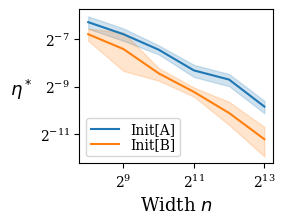

In [ ]:
import scipy
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

cm = sns.color_palette()#sns.color_palette("Set2")#sns.color_palette('tab10')

th = 2

list_n = [2**k for k in range(6,14)]

best_lrs1 = []
best_lrs2 = []

seeds = [6,7,8,9]
seeds2 = [6,7,8,9]

for n in list_n[th:]:
  best_lrs1 += get_best_lr(df1[df1['seed'].isin(seeds)], n, 100)
  best_lrs2 += get_best_lr(df2[df2['seed'].isin(seeds2)], n, 100)

df_lrs1 = pd.DataFrame(best_lrs1, columns=['n','lr'])
df_lrs2 = pd.DataFrame(best_lrs2, columns=['n','lr'])

fig, ax = plt.subplots(figsize=(2.5,2))

df_lrs1['log2_lr']=np.log(df_lrs1['lr'])/np.log(2)
df_lrs1['log2_n']=np.log(df_lrs1['n'])/np.log(2)

df_lrs2['log2_lr']=np.log(df_lrs2['lr'])/np.log(2)
df_lrs2['log2_n']=np.log(df_lrs2['n'])/np.log(2)

df_lrs1['th']= 0.2*df_lrs1['n']**(-.5)
df_lrs2['th']= 2.8*df_lrs1['n']**(-1.)


sns.lineplot(data=df_lrs1, x='n', y='lr', color=cm[0], ax=ax, label='Init[A]')
#sns.lineplot(data=df_lrs1, x='n', y='th', color=cm[0], ax=ax, label=r'$C_1 n^{-1/2}$', linestyle='--', linewidth=1.2, alpha=1.)

sns.lineplot(data=df_lrs2, x='n', y='lr', color=cm[1], ax=ax, label='Init[B]')
#sns.lineplot(data=df_lrs2, x='n', y='th', color=cm[1], ax=ax, label=r'$C_2 n^{-1}$', linestyle='--', linewidth=1.2, alpha=1.)



ax.set_xscale('log', base=2)
ax.set_yscale('log', base=2)

#ax.grid(alpha=0.4)

ax.set_xlabel(r'Width $n$', fontsize=13)
ax.set_ylabel(r'$\eta^*$', rotation=0, fontsize=13)

ax.yaxis.set_label_coords(-0.3,0.4)


L = ax.legend(labelspacing=.05, borderpad=0.35, loc='lower left')

# ax.annotate('Stability <-> Feature Learning', xy=(0.56, 0.9),
#             xycoords='figure fraction', fontsize=7)
# ax.annotate('Tradeoff', xy=(0.9, 0.55), xytext=(0.7, 0.85),
#             xycoords='figure fraction', textcoords='figure fraction', fontsize=7,
#             arrowprops=dict(arrowstyle="->"))

#fig.savefig('opt_lr_front.pdf', bbox_inches='tight')

# 2. LINEAR

In [ ]:
#Data

N=1000 #nb samples
N_test = 100
n, d=[128]*2 #input dim
r=4 #lora rank

s1,s2 = random.split(random.PRNGKey(111), num=2)
w= np.ones(d)
X = random.uniform(s1, (N,d))
# Y = np.sin(X.dot(w))
X_test = random.uniform(s2, (N_test,d))
# Y_test = np.sin(X_test.dot(w))


s1, s2, s3, s4, s5, s6, s7 = random.split(random.PRNGKey(10), num=7)

r_synth = 8
A_ = 1/np.sqrt(n) * random.normal(s5, (r_synth,n))
B_ = 1./np.sqrt(r_synth)*random.normal(s6, (n,r_synth))
Wout_ = 1./np.sqrt(n) * random.normal(s4, (n,n))

#generate synthetic data
X_test = random.normal(s7, (N_test,d))
synth_params = [A_, B_, Wout_]
Y = batched_predict_linear(synth_params, X)
Y_test = batched_predict_linear(synth_params, X_test)

In [ ]:
Y_test.shape

(100, 128)

In [ ]:
import tqdm

r_synth = 20
def sweep_n_linear(lrs, n, res, nb_steps, save_freq, seeds, init=1):
  for seed in seeds:
    s1, s2, s3, s4, s5, s6 = random.split(random.PRNGKey(seed), num=6)
    #A = 1/np.sqrt(n) * random.normal(s3, (r,n))
    if init==2:
      B = 1./np.sqrt(r)*random.normal(s3, (n,r))
      A = jnp.zeros((r,n))#1/np.sqrt(n) * random.normal(se+2, (r,n))

    elif init==1:
      B = jnp.zeros((n,r))#1./np.sqrt(r)*random.normal(se+3, (n,r))
      A = 1/np.sqrt(n) * random.normal(s3, (r,n))

    Wout = 1./np.sqrt(n) * random.normal(s4, (n,n))

    #generate synthetic data
    #1/np.sqrt(n) * random.normal(s5, (r_synth,n))
    # synth_params = [Win, Wh, 1/np.sqrt(n)*random.normal(s5, (r_synth, n)), 1./np.sqrt(r_synth)*random.normal(s6, (n,r_synth)), Wout]
    # Y = batched_predict(synth_params, X)
    # Y_test = batched_predict(synth_params, X_test)

    #adam(params, m_prev, v_prev, t, x, y, lr_in, lr_out)
    params = [A, B, Wout]
    for i, lr in enumerate(lrs):
      if i%20==0:
        print("lr="+str(lr) + ", ind=" + str(i) +", seed="+str(seed))

      new_params = params
      m = [jnp.zeros_like(p) for p in params]
      v = [jnp.zeros_like(p) for p in params]
      for j in range(nb_steps+1):
        if j%save_freq==0:
          A_,B_ = new_params[0:2]
          Az = jnp.abs(jnp.dot(A_, X.T)).mean(axis=1).tolist()
          BAz = jnp.abs(jnp.dot(B_, jnp.dot(A_,X.T))).mean(axis=1).tolist()
          res.append([n, lr, j, seed, float(loss_linear(new_params, X, Y)), float(loss_linear(new_params, X_test, Y_test)), Az, BAz])
        new_params, m, v = adam_linear(new_params, m, v, j+1, X, Y, lr)
  #   df = pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])
  # return pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])


def full_sweep_linear(lrs, list_n, nb_steps, save_freq, seeds, title, init=1):
  res = []
  for n in tqdm.tqdm(list_n):
    print("************* n="+str(n)+" ****************\n")
    print('\n')
    sweep_n_linear(lrs, n, res, nb_steps, save_freq, seeds, init)
    df = pd.DataFrame(res, columns=['n', 'lr', 'step', 'seed', 'train_loss', 'test_loss', 'Az', 'BAz'])
    df.to_csv(title+".csv")
  return df

In [ ]:
lrs = list(2**np.linspace(0, 15, 60)*1e-5)
#list_n = [2**k for k in range(6,14)]
list_n = [128]#[2**k for k in range(12,13)]

nb_steps = 100

#[90231, 101504, 232300]

df1_lin = full_sweep_linear(lrs, list_n, nb_steps, 2, [4,5], title='full_sweep_init1', init=1)
df2_lin = full_sweep_linear(lrs, list_n, nb_steps, 2, [4,5], title='full_sweep_init2', init=2)


#files.download('full_sweep_init1.csv')

  0%|          | 0/1 [00:00<?, ?it/s]

************* n=128 ****************



lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5


  0%|          | 0/1 [00:00<?, ?it/s]

************* n=128 ****************



lr=1e-05, ind=0, seed=4
lr=0.0003393602685918488, ind=20, seed=4
lr=0.011516539189873177, ind=40, seed=4
lr=1e-05, ind=0, seed=5
lr=0.0003393602685918488, ind=20, seed=5
lr=0.011516539189873177, ind=40, seed=5


100%|██████████| 1/1 [00:41<00:00, 41.51s/it]


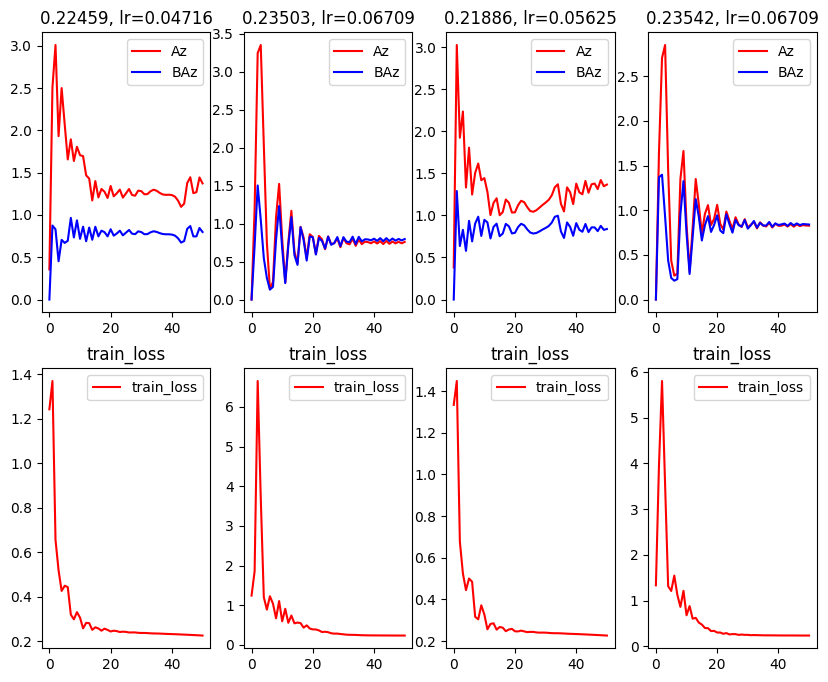

In [ ]:
def plot_avg(ax, df, seed):
  lr = get_best_lr(df, d, 100)[seed%2][1]
  dt = df[(df['lr']==lr) & (df['seed']==seed)]
  ax.plot(np.array([np.array(t) for t in dt['Az'].values]).mean(axis=1), label='Az', color='red')
  ax.plot(np.array([np.array(t) for t in dt['BAz'].values]).mean(axis=1), label='BAz', color='blue')
  ax.set_title("{:0.5f}".format(min(dt['train_loss']))+", lr={:0.5f}".format(lr))
  ax.legend()

def plot_best_loss(ax, df, seed):
  lr = get_best_lr(df2_lin, d, 100)[seed%2][1]
  dt = df[(df['lr']==lr) & (df['seed']==seed)]
  ax.plot(dt['train_loss'].values, label='train_loss', color='red')
  ax.set_title("train_loss")
  ax.legend()

fig, axes = plt.subplots(2,4, figsize=(10,8))

sd1 = 4
sd2 = 5
plot_avg(axes[0,0], df1_lin, sd1)
plot_avg(axes[0,1], df2_lin, sd1)
plot_avg(axes[0,2], df1_lin, sd2)
plot_avg(axes[0,3], df2_lin, sd2)

plot_best_loss(axes[1,0], df1_lin, sd1)
plot_best_loss(axes[1,1], df2_lin, sd1)
plot_best_loss(axes[1,2], df1_lin, sd2)
plot_best_loss(axes[1,3], df2_lin, sd2)

In [ ]:
lr = get_best_lr(df1_lin, 2048, 100)[0][1]
dt = df1_lin[(df1_lin['lr']==lr) & (df1_lin['seed']==4)]
dt['train_loss']

2040    1.122095
2041    0.547252
2042    0.289011
2043    0.423367
2044    0.429015
2045    0.323744
2046    0.276604
2047    0.271804
2048    0.274314
2049    0.272713
2050    0.269057
2051    0.270217
2052    0.268502
2053    0.254364
2054    0.260135
2055    0.254522
2056    0.256215
2057    0.250488
2058    0.256796
2059    0.248746
2060    0.252034
2061    0.255171
2062    0.248979
2063    0.247379
2064    0.251855
2065    0.256010
2066    0.253173
2067    0.246651
2068    0.247786
2069    0.251984
2070    0.251623
2071    0.246850
2072    0.245943
2073    0.248907
2074    0.251104
2075    0.249437
2076    0.245994
2077    0.245336
2078    0.247092
2079    0.249329
2080    0.250675
2081    0.249530
2082    0.246516
2083    0.244876
2084    0.245721
2085    0.247551
2086    0.249520
2087    0.250326
2088    0.248404
2089    0.245385
2090    0.244740
Name: train_loss, dtype: float64

In [ ]:
def sweep_n_optimized(lrs, n, res, nb_steps, save_freq, seeds, init=1):
  for seed in seeds:
    s1, s2, s3, s4, s5, s6 = random.split(random.PRNGKey(seed), num=6)
    Win = 1/np.sqrt(d)*random.normal(s1, (n,d))
    Wh = 1/np.sqrt(n)*random.normal(s2, (n,n))
    #A = 1/np.sqrt(n) * random.normal(s3, (r,n))
    if init==2:
      B = 1./np.sqrt(r)*random.normal(s3, (n,r))
      A = jnp.zeros((r,n))#1/np.sqrt(n) * random.normal(se+2, (r,n))

    elif init==1:
      B = jnp.zeros((n,r))#1./np.sqrt(r)*random.normal(se+3, (n,r))
      A = 1/np.sqrt(n) * random.normal(s3, (r,n))

    Wout = 1./np.sqrt(n) * random.normal(s4, (1,n))

    #generate synthetic data
    synth_params = [Win, Wh, 1/np.sqrt(n) * random.normal(s5, (r_synth,n)), 1./np.sqrt(r_synth)*random.normal(s6, (n,r_synth)), Wout]
    Y = batched_predict(synth_params, X)
    Y_test = batched_predict(synth_params, X_test)

    #adam(params, m_prev, v_prev, t, x, y, lr_in, lr_out)
    params = [Win, Wh, A, B, Wout]
    for i, lr in enumerate(lrs):
      print("lr="+str(lr) + ", ind="+str(i))
      lora_params = [A, B]
      other_params = [Win, Wh, Wout]
      m = [jnp.zeros_like(p) for p in lora_params]
      v = [jnp.zeros_like(p) for p in lora_params]
      for j in range(nb_steps+1):
        if j%save_freq==0:
          res.append([n, lr, j, seed, float(loss_optimized(lora_params, other_params, X, Y)), float(loss_optimized(lora_params, other_params, X_test, Y_test))])
        lora_params, m, v = adam_optimized(lora_params, other_params, m, v, j+1, X, Y, lr)
  #   df = pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])
  # return pd.DataFrame(res, columns=['lr', 'step', 'seed', 'train_loss', 'test_loss', 'params'])


'        -1.42854303e-01'

<Axes: xlabel='step'>

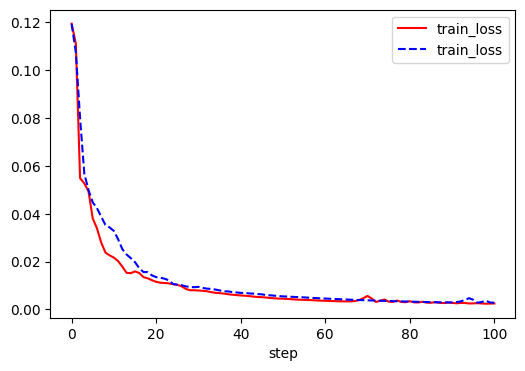

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

metric = 'train_loss'
dt1.plot(x='step', y=metric, ax=ax, color='red', legend='Init1')
dt2.plot(x='step', y=metric, ax=ax, color='blue', linestyle='--', legend='Init2')

In [ ]:
dt['params'].values[1][1].mean(axis=0), dt['params'].values[3][1].mean(axis=0)

(Array([ 0.05154203, -0.00792093,  0.02746734,  0.01423264], dtype=float32),
 Array([-0.24028137,  0.03851985,  0.2540977 , -0.01649722], dtype=float32))

In [ ]:
#new method

lr_ins = [0.] + list(10**np.linspace(-4, 1, 19))
lr_outs = 10**np.linspace(-5, 0, 19)


nb_steps = 100

df2 = sweep_adam_new(lr_ins, lr_outs, nb_steps, 1, [0])

lr_in=0.0, ind=0
lr_in=0.0001, ind=1
lr_in=0.00018957356524063754, ind=2
lr_in=0.00035938136638046257, ind=3
lr_in=0.0006812920690579615, ind=4
lr_in=0.001291549665014884, ind=5
lr_in=0.002448436746822227, ind=6
lr_in=0.004641588833612782, ind=7
lr_in=0.008799225435691074, ind=8
lr_in=0.016681005372000592, ind=9
lr_in=0.03162277660168379, ind=10
lr_in=0.05994842503189409, ind=11
lr_in=0.11364636663857254, ind=12
lr_in=0.21544346900318845, ind=13
lr_in=0.40842386526745217, ind=14
lr_in=0.7742636826811278, ind=15
lr_in=1.4677992676220706, ind=16
lr_in=2.782559402207126, ind=17
lr_in=5.27499706370262, ind=18
lr_in=10.0, ind=19


In [ ]:
input, output = get_best(df2, 100)[0]
input, output

***************** Best Train Loss at step 100 = 0.5030659437179565******************



(0.40842386526745217, 0.04084238652674522)

In [ ]:
df1 = pd.read_csv('/content/all.csv')
df2 = pd.read_csv('/content/all_new.csv')

in1,out1 = (0.0316227766016837, 0.0215443469003188)
in2,out2 = (0.05994842503189409, 0.0)

dt1 = df1[(df1['output']==out1) & (df1['input']==in1)]
dt2 = df2[(df2['output']==out2) & (df2['input']==in2)]


(0.0, 0.1)

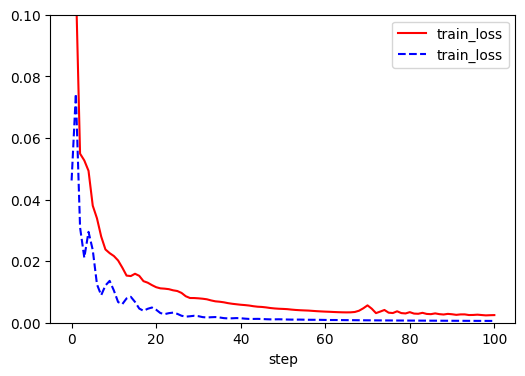

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

metric = 'train_loss'
dt1.plot(x='step', y=metric, ax=ax, color='red', legend='Init1')
dt2.plot(x='step', y=metric, ax=ax, color='blue', linestyle='--', legend='New')

ax.set_ylim([0,0.1])